In [ ]:
!git clone https://github.com/Dt-Pham/Advanced-Lane-Lines.git
%cd Advanced-Lane-Lines/

Cloning into 'Advanced-Lane-Lines'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 104 (delta 3), reused 0 (delta 0), pack-reused 100
Receiving objects: 100% (104/104), 95.77 MiB | 21.60 MiB/s, done.
Resolving deltas: 100% (6/6), done.
/content/Advanced-Lane-Lines


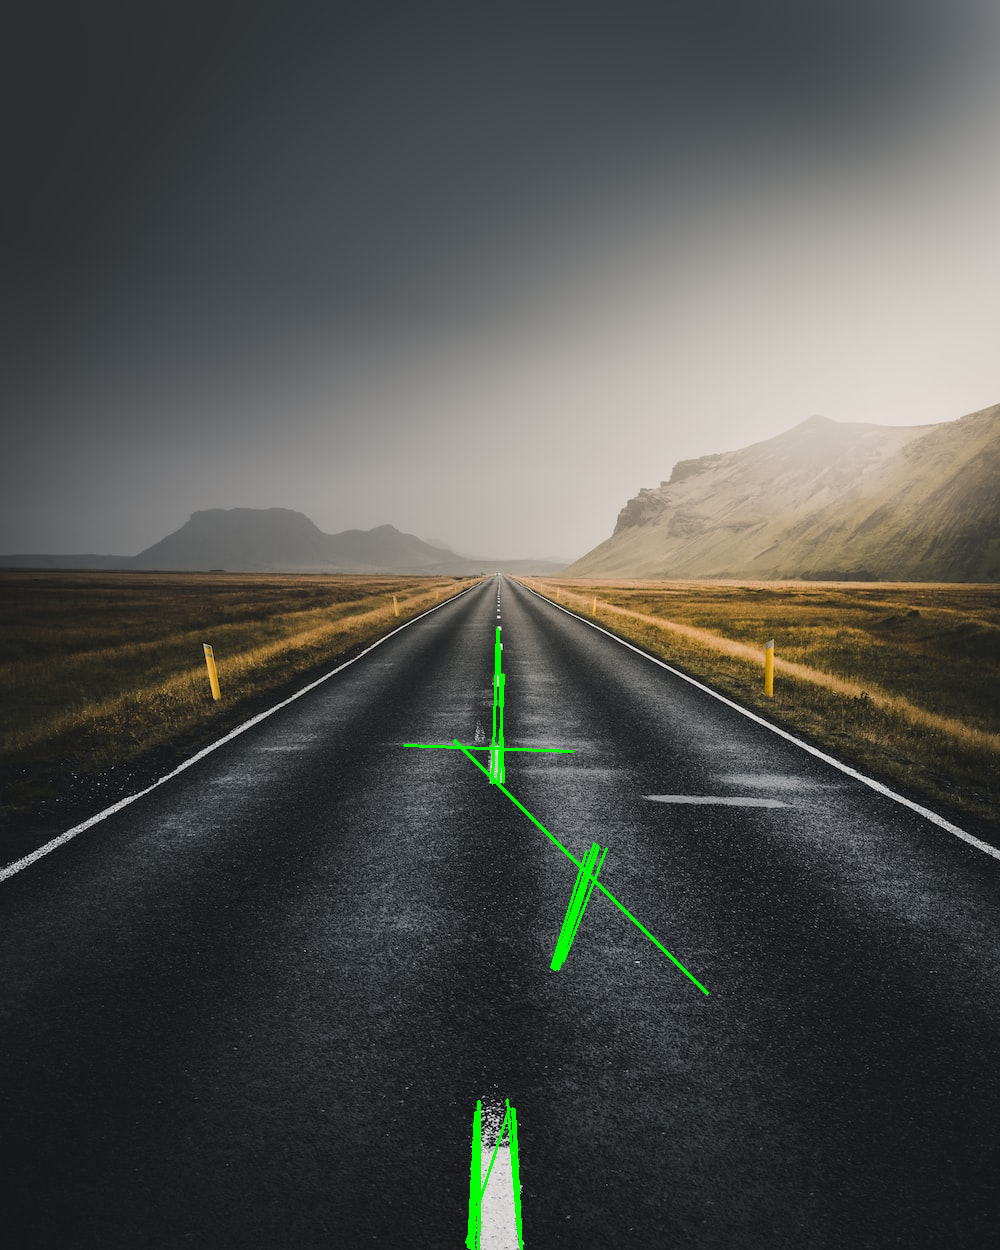

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Import cv2_imshow for Colab

def detect_lanes(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Define a region of interest (ROI)
    height, width = edges.shape
    roi_vertices = [(0, height), (width / 2, height / 2), (width, height)]
    mask = np.zeros_like(edges)
    cv2.fillPoly(mask, [np.array(roi_vertices, np.int32)], 255)
    masked_edges = cv2.bitwise_and(edges, mask)

    # Detect lines using Hough Transform
    lines = cv2.HoughLinesP(masked_edges, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=50)

    # Draw the detected lane lines on a copy of the original image
    lane_image = np.copy(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(lane_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return lane_image

# Load an example image (replace with your own image)
image = cv2.imread("lane_image.jpg")

# Detect lanes in the image
lane_detected_image = detect_lanes(image)

# Display the result using cv2_imshow
cv2_imshow(lane_detected_image)


  curvature, position = calculate_curvature_and_position(left_line, right_line, height, width)

  curvature, position = calculate_curvature_and_position(left_line, right_line, height, width)



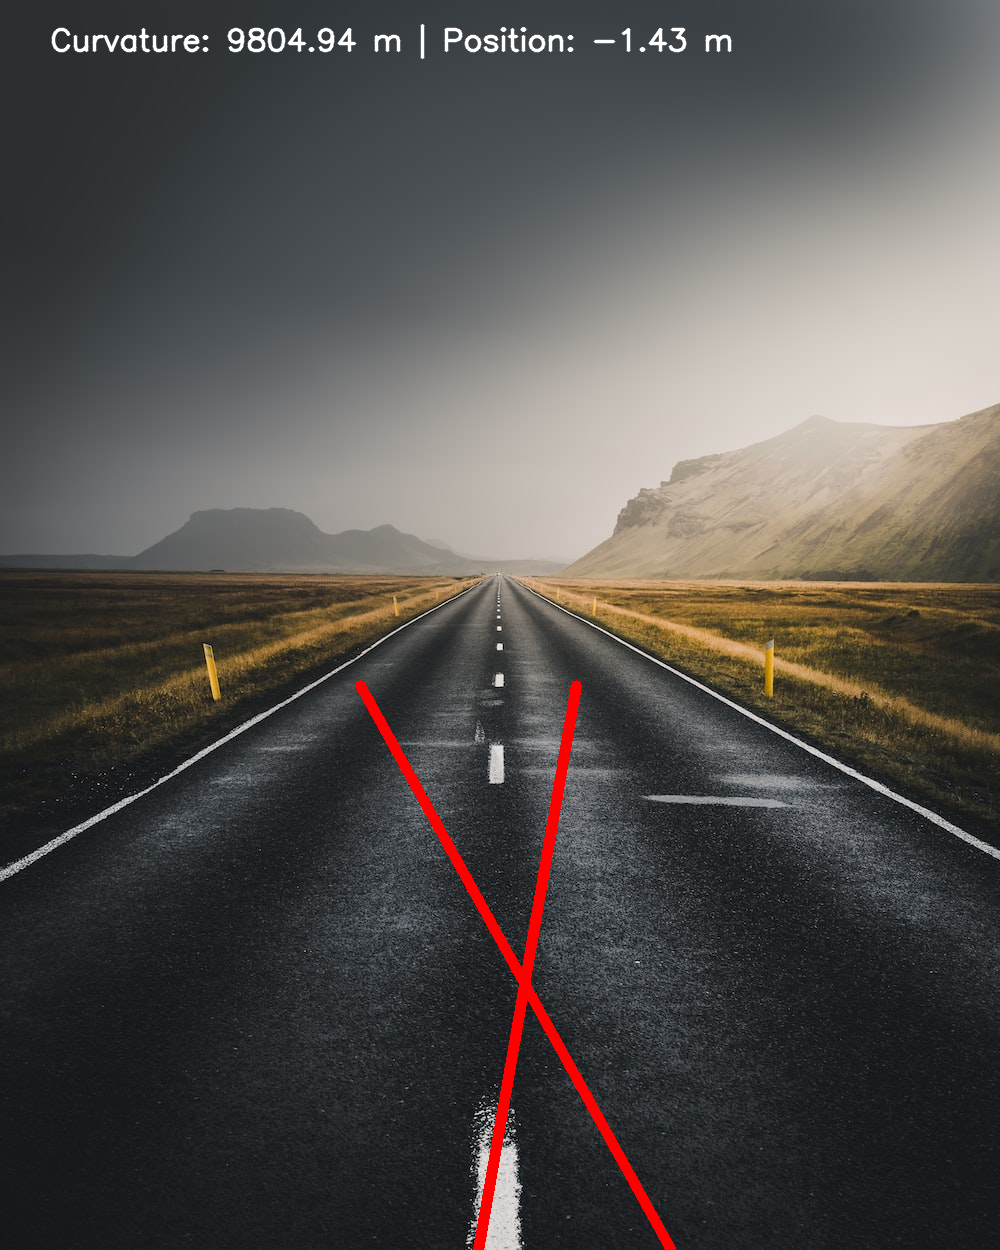

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Import cv2_imshow for Colab

def detect_lanes(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Define a region of interest (ROI)
    height, width = edges.shape
    roi_vertices = [(0, height), (width / 2, height / 2), (width, height)]
    mask = np.zeros_like(edges)
    cv2.fillPoly(mask, [np.array(roi_vertices, np.int32)], 255)
    masked_edges = cv2.bitwise_and(edges, mask)

    # Detect lines using Hough Transform
    lines = cv2.HoughLinesP(masked_edges, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=50)

    # Separate lines into left and right lanes
    left_lines, right_lines = [], []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            slope = (y2 - y1) / (x2 - x1 + 1e-5)  # Avoid division by zero
            if slope < 0:
                left_lines.append(line[0])
            else:
                right_lines.append(line[0])

    # Fit a linear regression line to the left and right lane lines
    left_line = fit_lane_line(left_lines, height)
    right_line = fit_lane_line(right_lines, height)

    # Draw the detected lane lines on a copy of the original image
    lane_image = np.copy(image)
    draw_lane_lines(lane_image, left_line, right_line)

    # Calculate lane curvature and position relative to the center
    curvature, position = calculate_curvature_and_position(left_line, right_line, height, width)

    # Add curvature and position information to the image
    add_curvature_and_position_info(lane_image, curvature, position)

    return lane_image

def fit_lane_line(lines, height):
    if len(lines) > 0:
        lines = np.array(lines)
        x1_mean = np.mean(lines[:, 0])
        y1_mean = np.mean(lines[:, 1])
        x2_mean = np.mean(lines[:, 2])
        y2_mean = np.mean(lines[:, 3])
        slope = (y2_mean - y1_mean) / (x2_mean - x1_mean + 1e-5)  # Avoid division by zero
        intercept = y1_mean - slope * x1_mean
        y1 = height
        x1 = int((y1 - intercept) / (slope + 1e-5))
        y2 = int(height / 2) + 60  # Adjust for the region of interest
        x2 = int((y2 - intercept) / (slope + 1e-5))
        return [(x1, y1, x2, y2)]
    else:
        return []

def draw_lane_lines(image, left_line, right_line):
    if left_line:
        x1, y1, x2, y2 = left_line[0]
        cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 10)
    if right_line:
        x1, y1, x2, y2 = right_line[0]
        cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 10)

def calculate_curvature_and_position(left_line, right_line, height, width):
    if left_line and right_line:
        left_x1, _, left_x2, _ = left_line[0]
        right_x1, _, right_x2, _ = right_line[0]

        lane_width_pixels = right_x1 - left_x1
        lane_width_meters = 3.7  # Example: Assuming lane width is 3.7 meters

        # Calculate lane curvature
        y_eval = height  # Evaluate curvature at the bottom of the image
        y_m_per_pix = 30 / height  # Example: Convert to meters per pixel (assuming 30 meters of visible road)
        x_m_per_pix = lane_width_meters / lane_width_pixels

        left_fit_cr = np.polyfit(np.array([left_x1, left_x2]) * x_m_per_pix, np.array([height, height / 2]) * y_m_per_pix, 2)
        right_fit_cr = np.polyfit(np.array([right_x1, right_x2]) * x_m_per_pix, np.array([height, height / 2]) * y_m_per_pix, 2)

        left_curvature = ((1 + (2 * left_fit_cr[0] * y_eval * y_m_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
        right_curvature = ((1 + (2 * right_fit_cr[0] * y_eval * y_m_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])

        curvature = (left_curvature + right_curvature) / 2

        # Calculate position of the vehicle relative to the center
        lane_center_x = (left_x1 + right_x1) / 2
        image_center_x = width / 2
        position = (image_center_x - lane_center_x) * x_m_per_pix

        return curvature, position
    else:
        return None, None

def add_curvature_and_position_info(image, curvature, position):
    info_text = "Curvature: {:.2f} m | Position: {:.2f} m".format(curvature, position)
    cv2.putText(image, info_text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

# Load an example image (replace with your own image)
image = cv2.imread("lane_image.jpg")

# Detect lanes in the image
lane_detected_image = detect_lanes(image)

# Display the result using cv2_imshow
cv2_imshow(lane_detected_image)


This advanced version of the code includes:

Separation of detected lines into left and right lanes.
Fitting linear regression lines to the left and right lane lines.
Calculation of lane curvature and vehicle position relative to the center of the lane.
Drawing the detected lane lines with lane curvature and